# Imports

In [1]:
# help here: 
#  - https://www.youtube.com/watch?v=nNvPvvuPnGs 
#  - https://github.com/rsreetech/LDATopicModelling/blob/main/LDADemo.ipynb

import os
import time
import warnings
from IPython.display import clear_output, HTML

import numpy as np
import pandas as pd
from pandarallel import pandarallel

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
from tabulate import tabulate
from wordcloud import WordCloud
import pprint

from PIL import Image
from PIL import ImageOps
from PIL import ImageFilter

import nltk
from nltk.corpus import stopwords

from scipy.sparse import csr_array

from sklearn.decomposition import LatentDirichletAllocation
from sklearn.decomposition import NMF
from sklearn.decomposition import PCA
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import StandardScaler
from sklearn.manifold import TSNE

import gensim
from gensim import corpora

# libraries for visualization
import pyLDAvis
import pyLDAvis.gensim

# Configuration

In [2]:
# PREVIEW PHASE
PREVIEW_REVIEW_SIZE = 1000

# EXTRACT PHASE
CHUNK_SIZE = 10000
EXTRACT_PARQUET = True

# PREPROCESS IMAGES PHASE
PREPROCESS_IMAGES = True

# SAMPLINg
SAMPLING_REVIEW_SIZE = 1000
SAMPLING_PHOTOS_SIZE = 100

ORIGINAL_DATASET_DIR = 'data/original/yelp_dataset/'
ORIGINAL_PHOTOS_DIR = 'data/original/yelp_photos/'
WORK_DATASET_DIR = 'data/work/yelp_dataset/'
WORK_PHOTOS_DIR = 'data/work/yelp_photos/'

PREFIX_YELP = 'yelp_academic_dataset_'

warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=UserWarning)
warnings.simplefilter(action='ignore', category=matplotlib.MatplotlibDeprecationWarning)
sns.set()

# Fonctions

In [3]:
def time_from(time_start):
    time_total = round(time.time() - time_start, 0)
    minutes = time_total // 60
    seconds = time_total - minutes * 60
    return f'{minutes:.0f}mn {seconds:.0f}s'
    
def list_files(dir, extension='json', print_result = True):
    paths = {(file.split('.')[0]).split(PREFIX_YELP)[1]: dir + file for file in os.listdir(dir) if file.endswith('.' + extension)}
    if print_result:
        files = [[os.path.basename(paths[name]), file_size(paths[name])] for name in paths]
        print(tabulate(files, headers=['Name', 'Size']))
    return paths

def file_size(path, unit='Gb', precision=2, only_value = False):
    exp = 3
    if (unit=='ko'):
        exp = 1
    elif (unit == 'Mb'):
        exp = 2
    else:
        exp = 3
        unit = 'Gb'

    value = round((os.path.getsize(path)/(1024**exp)), precision)
    if only_value:
        return value
    else:
        return str(value) + unit

def preview_dataset(path):
    df = pd.read_json(path, lines=True, nrows=PREVIEW_REVIEW_SIZE)
    display(df.sample(5))
    display(df.dtypes)

    return df   

def get_negative_sw():
    return [sw for sw in stopwords.words('english') if sw not in ['not', 'too', 'very', 'few',  "don't", "aren't", 'couldn',
                                                                  "couldn't", 'didn', "didn't", 'doesn', "doesn't", 'hadn',
                                                                  "hadn't", 'hasn', "hasn't", 'haven', "haven't", 'isn',
                                                                  "isn't", 'mightn', "mightn't", 'mustn', "mustn't", 'needn',
                                                                  "needn't", 'shan', "shan't", 'shouldn', "shouldn't", 'wasn',
                                                                  "wasn't", 'weren', "weren't", 'won', "won't", 'wouldn', "wouldn't"]
           ]

def drop_words(tokens, words):
    return [token for token in tokens if token not in words]

def preprocess_text(text):
    # normalization
    text = text.lower().strip()

    return text 

def tokenize(text):
    from nltk import RegexpTokenizer
    from nltk.corpus import stopwords
    from nltk.stem import WordNetLemmatizer

    # Tokenization
    tokenizer = RegexpTokenizer(r'\w+')
    tokens = tokenizer.tokenize(text)

    # Lematization
    lemmatizer = WordNetLemmatizer()
    tokens = [lemmatizer.lemmatize(word, pos='a') for word in tokens]
    tokens = [lemmatizer.lemmatize(word, pos='v') for word in tokens]
    tokens = [lemmatizer.lemmatize(word, pos='n') for word in tokens]

    # Keep tokens with length > 2
    tokens = [token for token in tokens if len(token) > 2]

    return tokens

def extract_n_grams(token_list, n_list):
    import nltk
    n_grams = []
    for n in n_list:
        n_grams.append([' '.join(n_gram) for n_gram in nltk.ngrams(token_list,n)])

    new_token_list = []
    for n_gram in n_grams:
        new_token_list  = new_token_list + n_gram

    if 1 in n_list:
        new_token_list = token_list + new_token_list

    return new_token_list

def word_cloud(text):
    wordcloud = WordCloud(background_color = 'white', max_words = 50).generate(text)
    plt.imshow(wordcloud)
    plt.axis("off")
    plt.show();

# Extractions des sujets des reviews

## Prévisualiastions des datasets

In [4]:
files = list_files(ORIGINAL_DATASET_DIR)
print('')
print(tabulate([[k,v] for k,v in files.items()]))

Name                                 Size
-----------------------------------  ------
yelp_academic_dataset_business.json  0.11Gb
yelp_academic_dataset_checkin.json   0.27Gb
yelp_academic_dataset_review.json    4.98Gb
yelp_academic_dataset_tip.json       0.17Gb
yelp_academic_dataset_user.json      3.13Gb

--------  --------------------------------------------------------------
business  data/original/yelp_dataset/yelp_academic_dataset_business.json
checkin   data/original/yelp_dataset/yelp_academic_dataset_checkin.json
review    data/original/yelp_dataset/yelp_academic_dataset_review.json
tip       data/original/yelp_dataset/yelp_academic_dataset_tip.json
user      data/original/yelp_dataset/yelp_academic_dataset_user.json
--------  --------------------------------------------------------------


In [5]:
preview_dfs = {}
for name in files:
    print(f'PREVIEW {name}\n=====================\n')
    preview_dfs[name] = preview_dataset(files[name])
    print('')

PREVIEW business



,business_id,name,address,city,state,postal_code,latitude,longitude,stars,review_count,is_open,attributes,categories,hours
441,516L9-ZWyqVgzqjP5uW7Jg,The Corner Cafe and Deli,"100 S Ashley Dr, Ste 220",Tampa,FL,33602,27.944457,-82.457824,4.0,6,1,"{'BusinessAcceptsCreditCards': 'True', 'GoodFo...","Sandwiches, Cafes, Burgers, Food, Restaurants","{'Monday': '7:30-15:0', 'Tuesday': '7:30-15:0'..."
923,o_SARUTRPagpzpaWw6ZQeA,Stefanec's South Barber Shop,772 Indian Rocks Rd N,Bellair,FL,33770,27.923586,-82.813244,4.5,11,1,"{'ByAppointmentOnly': 'False', 'RestaurantsPri...","Barbers, Beauty & Spas","{'Monday': '9:0-18:0', 'Tuesday': '9:0-18:0', ..."
144,PYW8Buz8S8LpjIe6mZTAcw,Payless Liquors,954 N State Rd 135,Greenwood,IN,46143,39.632280,-86.158674,3.5,13,1,"{'BikeParking': 'True', 'BusinessAcceptsCredit...","Food, Beer, Wine & Spirits",None
526,TGfPJHImEq6AQL9a1laxlg,Chick-fil-A,9711 Roosevelt Blvd,Philadelphia,PA,19114,40.081780,-75.026791,4.0,80,1,"{'RestaurantsPriceRange2': '1', 'BusinessAccep...","Event Planning & Services, American (Tradition...","{'Monday': '0:0-0:0', 'Tuesday': '10:30-18:0',..."
146,M_THnNDHs29aylcK-JqS1A,Professional Healthcare of Pinellas,1839 Central Ave,Saint Petersburg,FL,33713,27.771357,-82.658612,1.5,6,1,"{'ByAppointmentOnly': 'True', 'BusinessAccepts...","Doctors, Internal Medicine, Health & Medical",None


business_id      object
name             object
address          object
city             object
state            object
postal_code      object
latitude        float64
longitude       float64
stars           float64
review_count      int64
is_open           int64
attributes       object
categories       object
hours            object
dtype: object


PREVIEW checkin



,business_id,date
529,-Et_AB_ZBMj6EoxE_f5veg,"2016-10-10 14:45:45, 2016-12-22 16:36:42, 2017..."
951,-SZ-p4o6gJPOJ--HA3NKcw,"2010-02-13 02:45:53, 2010-08-08 01:24:10, 2010..."
967,-SyZFk1jVIsyZbJ3QvbEmA,"2016-02-23 21:02:33, 2016-11-25 14:56:52, 2020..."
816,-OffMC_1lTuedMvULJJ7Bg,"2011-09-04 14:57:20, 2012-08-05 18:50:08, 2012..."
193,-4UxcA0lUfURC-4pNsPRcg,2011-10-12 13:29:53


business_id    object
date           object
dtype: object


PREVIEW review



,review_id,user_id,business_id,stars,useful,funny,cool,text,date
363,eY8zc9p7Kiv9ATEtNqAdaw,t4pFEaPnTGlShIEaa7y9pg,dDn_NVOQh9F-t153S035Ew,5,0,0,0,The food here is so great and fresh. I don't s...,2017-09-09 02:04:25
55,EoN2xyKvTTn9B-z1grhYxw,DBYhpb5hrAYgQjQaMhNYyQ,oJ4ik-4PZe6gexxW-tSmsw,4,0,0,0,I love the Brewpub for their variety of dishes...,2016-10-26 15:29:56
614,YPrUSWTzdbOQnRShO8caPw,Q503wfkVgYYRisTYSyWYww,oha2U5XJzc6IQdenpsxN1Q,3,2,0,1,A small aquarium that is interesting mainly fo...,2008-12-06 04:05:35
819,bg3TAimbMppppLUTfN46nA,R9VOYcIWbNA3Q3qiWF2SsQ,EIlFs8kybcG-l60GJjNUIA,1,0,0,0,AVOID AT ALL COSTS\nBy far the worst pizza I'v...,2017-02-09 06:35:49
470,zHqZ1ym04EB_4IXppIX5Eg,mrV0BOkFOnMWzgYJrS3i0g,c7OfNRMIqAhtNOMEat3Rbg,3,1,0,0,The long and the short of it: A romantic littl...,2012-07-16 17:27:36


review_id              object
user_id                object
business_id            object
stars                   int64
useful                  int64
funny                   int64
cool                    int64
text                   object
date           datetime64[ns]
dtype: object


PREVIEW tip



,user_id,business_id,text,date,compliment_count
567,a8D8jgSWhY44LI1EKU2MhA,FKgkGKRJYppEGCYuK_DOGg,"Make your own opinion, but the "" spicy Honey g...",2013-12-21 00:01:42,0
597,3XzhO2aJdvVtYhKOCJsPrg,cOoTIQ0RcudE1R5aRVZzdw,So fresh. So nice. Just pull off that freeway ...,2013-02-11 17:52:18,0
680,QzCpV9WM3NYUuh89Wa5lRw,I3ZLcrGzj-QN5vFgaJFrAg,"Worst store ever, 0 lefty golf clubs for juniors",2016-04-23 20:14:58,0
998,W7iLDP6GY4joKZ1zSCOEfA,dLVXcceTQlOYJRz9N4M0xg,Wednesday is half price wine!,2014-03-20 22:58:05,0
871,pctgUvk8c3bDpNZKiSB9hg,HSv0Pe45yPAs6PgwlcTPcg,Checkout their website for daily blackboard sp...,2015-05-17 20:38:56,0


user_id                     object
business_id                 object
text                        object
date                datetime64[ns]
compliment_count             int64
dtype: object


PREVIEW user



,user_id,name,review_count,yelping_since,useful,funny,cool,elite,friends,fans,...,compliment_more,compliment_profile,compliment_cute,compliment_list,compliment_note,compliment_plain,compliment_cool,compliment_funny,compliment_writer,compliment_photos
939,nudeZ4nKoq49qpFRWCXXDA,K.,14,2010-08-05 13:53:53,52,5,1,,"U8mLozomIaXMLsVNfkYpuw, rJkMnakAQwuinAtC32Fa4A...",2,...,0,0,0,0,1,0,0,0,0,1
716,_KeuaQCbJsZ7cipYpBPxDQ,Jerry,9,2010-05-21 05:27:31,21,3,10,,"z4s-2yeDBXXbKr-VxSF-gg, MVJx4vJwXqV7Ln-7D6qBeg...",11,...,1,0,0,0,1,0,2,2,1,1
545,ojxS1v-8nUvEEx4DlsPQrA,Kristin,655,2010-05-18 03:07:02,621,124,290,"2011,2012,2013,2014,2015,2016,2017,2018,2019,2...","i5o9heILJtx3Yrwm-BdviQ, HvQ45V3LxGbY6-YZ97cvqQ...",34,...,2,3,0,0,28,19,23,23,7,1
700,0iq45WV_h_j8SXjR4ytcJg,A,186,2009-12-08 23:21:45,669,301,379,,"dXpgRqVIJZZcD87Tf9DtUQ, 5pDJuri4g3Wfes8GGlnudA...",46,...,2,1,0,0,7,22,18,18,4,4
658,clLKvGH-1oauaInqjp3jkw,Ag,53,2011-03-14 22:13:09,90,22,41,2012,"dhw6ghjr3CNRuuayG-eWkw, B0_pdVl6s92PKS5Wzgn2sA...",11,...,0,0,0,1,18,4,5,5,5,2


user_id                object
name                   object
review_count            int64
yelping_since          object
useful                  int64
funny                   int64
cool                    int64
elite                  object
friends                object
fans                    int64
average_stars         float64
compliment_hot          int64
compliment_more         int64
compliment_profile      int64
compliment_cute         int64
compliment_list         int64
compliment_note         int64
compliment_plain        int64
compliment_cool         int64
compliment_funny        int64
compliment_writer       int64
compliment_photos       int64
dtype: object

<Axes: xlabel='stars'>

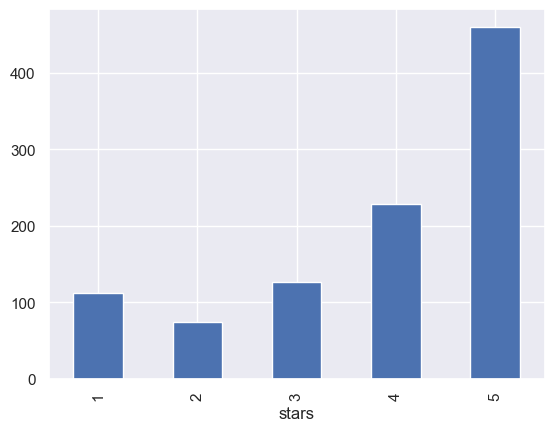

In [6]:
preview_dfs['review']['stars'].value_counts().sort_index().plot.bar()

In [7]:
preview_dfs['business']['categories'].unique()[0:20]

array(['Doctors, Traditional Chinese Medicine, Naturopathic/Holistic, Acupuncture, Health & Medical, Nutritionists',
       'Shipping Centers, Local Services, Notaries, Mailbox Centers, Printing Services',
       'Department Stores, Shopping, Fashion, Home & Garden, Electronics, Furniture Stores',
       'Restaurants, Food, Bubble Tea, Coffee & Tea, Bakeries',
       'Brewpubs, Breweries, Food',
       'Burgers, Fast Food, Sandwiches, Food, Ice Cream & Frozen Yogurt, Restaurants',
       'Sporting Goods, Fashion, Shoe Stores, Shopping, Sports Wear, Accessories',
       'Synagogues, Religious Organizations',
       'Pubs, Restaurants, Italian, Bars, American (Traditional), Nightlife, Greek',
       'Ice Cream & Frozen Yogurt, Fast Food, Burgers, Restaurants, Food',
       'Department Stores, Shopping, Fashion',
       'Vietnamese, Food, Restaurants, Food Trucks',
       'American (Traditional), Restaurants, Diners, Breakfast & Brunch',
       'General Dentistry, Dentists, Health & Medic

In [58]:
review = preview_dfs['review']
for star in range(1,6):
    title = HTML(f'<h3 style="">Note = {star}<br><hr></h3>')
    display(title)
    for index in review[review['stars']==star].sample(2, random_state=0).index:
        stars, text = review.loc[index, ['stars', 'text']].values
        quote = HTML(f'<div style="border-left: 4px solid yellow; padding-left:10px; margin-bottom:20px;">{text}</div>')
        display(quote)

<Axes: xlabel='class'>

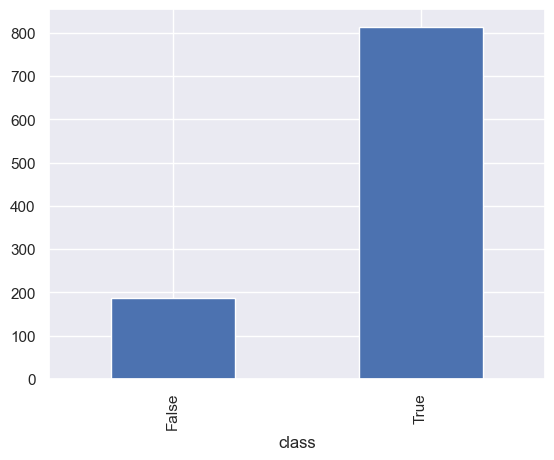

In [9]:
preview_dfs['review']['class'] = preview_dfs['review']['stars'] > 2
preview_dfs['review']['class'].value_counts().sort_index().plot.bar()

In [10]:
sampling_coef_bad = preview_dfs['review']['class'].value_counts()[False]/preview_dfs['review']['class'].value_counts()[True]

## Extraction d'un échantillons de reviews

### Recensement des catégories de business

In [11]:
business = pd.read_json(ORIGINAL_DATASET_DIR + PREFIX_YELP + 'business.json', lines=True)
business['_cats'] = business['categories'].apply(lambda x: [cat.strip() for cat in x.split(',')] if x else [])
business['_cats'].sample(5)

32864    [Pediatric Dentists, Orthodontists, Health & M...
13535         [Fashion, Shopping, Bridal, Flowers & Gifts]
75660    [Event Planning & Services, Photography Stores...
15696    [Towing, Transmission Repair, Auto Repair, Aut...
60580                        [Italian, Restaurants, Pizza]
Name: _cats, dtype: object

In [12]:
categories = set()
for index in business.index:
    categories.update(business.loc[index, '_cats'])

In [13]:
[categorie for categorie in categories if 'restaurant' in categorie.lower()]

['Restaurant Supplies', 'Pop-Up Restaurants', 'Restaurants']

In [14]:
[categorie for categorie in categories if 'food' in categorie.lower()]

['Seafood Markets',
 'Soul Food',
 'Food Delivery Services',
 'Ethnic Food',
 'Food Banks',
 'Fast Food',
 'Food Trucks',
 'Food Court',
 'Comfort Food',
 'Food Tours',
 'Specialty Food',
 'Food',
 'Imported Food',
 'Food Stands',
 'Do-It-Yourself Food',
 'Live/Raw Food',
 'Seafood']

### Création des fichiers parquets

- par chunk de 100000
- Filtrage des reviews sur categorie "restaurants"
- Séparation par note
- Ajout des infos business
- Limite en quantité

In [15]:
restaurants_ids = business[~business['categories'].isna() & business['categories'].str.contains('Restaurants')]['business_id'].to_list()
print(f'{len(restaurants_ids)} business sont des Restaurants')

52268 business sont des Restaurants


In [16]:
reviews_files = {stars:WORK_DATASET_DIR + f'reviews_stars_{stars}.parquet' for stars in range(1,6)}
reviews_counts = {stars:0 for stars in range(1,6)}
reviews_append = {stars:False for stars in range(1,6)}

business['review_count_q'] = pd.qcut(business.review_count, q=4, labels=['c1', 'c2', 'c3', 'c4'])
if EXTRACT_PARQUET:
    for chunk in pd.read_json(ORIGINAL_DATASET_DIR + PREFIX_YELP + 'review.json', lines=True, chunksize=10000):
        restaurant_reviews = chunk[chunk['business_id'].isin(restaurants_ids)].copy()
        restaurant_reviews = restaurant_reviews.join(business.set_index('business_id'), on='business_id', rsuffix='_business')

        for stars in reviews_counts:
            if reviews_counts[stars] < SAMPLING_REVIEW_SIZE:
                reviews = restaurant_reviews[restaurant_reviews['stars'] == stars]
                keep_rows = min(SAMPLING_REVIEW_SIZE - reviews_counts[stars], reviews.shape[0])
                reviews_counts[stars] = reviews_counts[stars] + keep_rows
                reviews.iloc[:keep_rows].to_parquet(reviews_files[stars], engine='fastparquet', append=reviews_append[stars])
                reviews_append[stars] = True

        if sum([reviews_counts[i] for i in reviews_counts]) == SAMPLING_REVIEW_SIZE*len(reviews_counts): break

def get_reviews(max_stars = 2, stars = None):
    if stars:
        return pd.read_parquet(reviews_files[stars])
        
    df = pd.DataFrame()
    for stars in range(1, max_stars + 1):
        df = pd.concat([df, pd.read_parquet(reviews_files[stars])])
    return df

In [17]:
get_reviews(max_stars=1).dtypes

review_id                 object
user_id                   object
business_id               object
stars                      int64
useful                     int64
funny                      int64
cool                       int64
text                      object
date              datetime64[ns]
name                      object
address                   object
city                      object
state                     object
postal_code               object
latitude                 float64
longitude                float64
stars_business           float64
review_count               int64
is_open                    int64
attributes                object
categories                object
hours                     object
_cats                     object
review_count_q            object
dtype: object

## Analyse des echantillons de reviews 

### Nuages de mots par note

In [18]:
def review_word_cloud(reviews, no_below = 4, no_above = 0.1, verbose = 0):

    # Duplicates
    nb_duplicated = reviews.duplicated(subset='text').sum()
    reviews.drop_duplicates(subset='text', keep='first', inplace=True)

    if verbose > 0:
        print(f'Nombre de textes dupliqués supprimés: {nb_duplicated}')
        print(f'Il y a {reviews.shape[0]} enregistrements')

    if verbose > 0: display(reviews.sample(5, random_state=0).loc[:, ['stars', 'text']])
    
    # Initialize paralellize and sampling
    pandarallel.initialize(progress_bar=(verbose > 0), verbose=False)
    
    # Preprocess
    if verbose > 0: print('\nPreprocess\n=================\n')
    reviews['text'] = reviews['text'].parallel_apply(preprocess_text)

    # Preprocess (tokenize, lemmatization)
    if verbose > 0: print('\nTokenize\n=================\n')
    reviews['tokens'] = reviews['text'].parallel_apply(tokenize)
    reviews.drop(columns=['text'], inplace=True)

    stop_words = get_negative_sw()
    reviews['tokens'] = reviews['tokens'].parallel_apply(drop_words, args=(stop_words,))
    reviews['text_len'] = reviews['tokens'].str.join(' ').str.len()

    if verbose > 0:
        print('')
        tokens_infos = [
            ['Nombre de tokens unique initial dans le dataframe', nb_words_original],
            ['Nombre de stopwords', len(stop_words)],
            ['Nombre de tokens unique restant dans le dataframe', len(set(reviews['tokens'].sum()))]
        ]
        print(tabulate(tokens_infos))

    # View result sample
    if verbose > 0: 
        print('\nEchantillon du resultat\n=================\n')
        display(reviews.sample(5, random_state=0).loc[:, ['stars', 'tokens']])

    # Calc and view text lengths
    if verbose > 0: 
        print('\nAnalyse des longeurs de text\n=================\n')
        reviews.boxplot(column='text_len', showfliers=True, vert=False)
        plt.show()

    # Text length
    total_text_len = reviews['text_len'].sum()
    if verbose > 0: 
        print(f'Longeur total du texte dans le dataframe: {total_text_len}')
        print('')

    # Visualisation Word clound on sample
    # Sampling for word cloud
    cloud_sample_size = min(reviews.shape[0], 1000)
    sample = reviews.sample(cloud_sample_size, random_state=0)['tokens']

    # Filter extremes filter
    dictionary = corpora.Dictionary(list(sample))
    dictionary.filter_extremes(no_below=2, no_above=0.1)
    sample.parallel_apply(lambda tokens: [token for token in tokens if token in list(dictionary.values())])
    
    if verbose > 0: print(f'\nVisualisation du nuage de mot d\'un échantillon de {cloud_sample_size} lignes\n=================\n')
    
    sample_text = ' '.join(sample.str.join(' ').values)
    word_cloud(text=sample_text)
    print('')

Note = 5


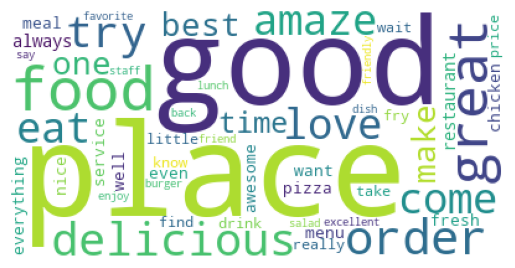


Note = 4


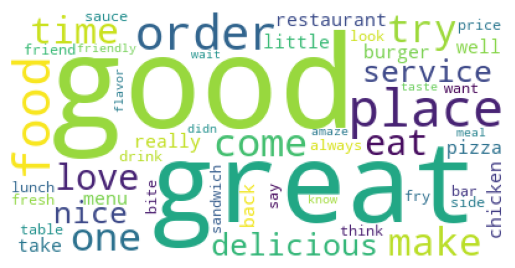


Note = 3


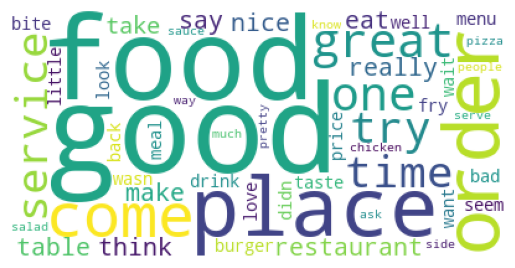


Note = 2


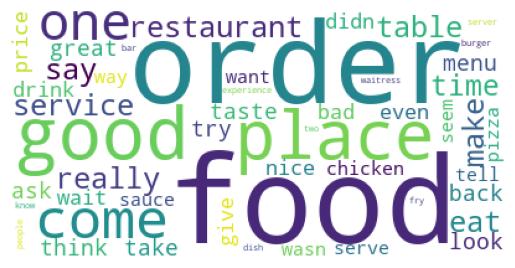


Note = 1


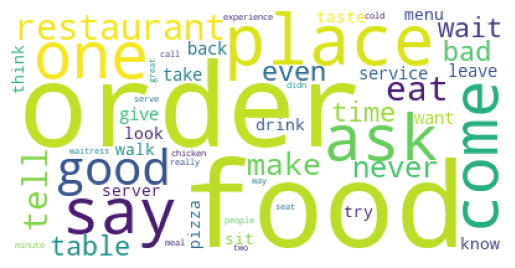

In [19]:
for stars in range(5,0,-1):
    print(f'Note = {stars}')
    review_word_cloud(reviews=get_reviews(stars=stars),
                      no_below=2,
                      no_above= 0.3)

### Sac de mots (TF-IDF) et visualisation (PCA/TSNE)

In [20]:
def tf_idf(reviews, min_df = 4, max_df = 100, verbose = 0):

    # Duplicates
    nb_duplicated = reviews.duplicated(subset='text').sum()
    reviews.drop_duplicates(subset='text', keep='first', inplace=True)

    if verbose > 0:
        print(f'Nombre de textes dupliqués supprimés: {nb_duplicated}')
        print(f'Il y a {reviews.shape[0]} enregistrements')
    
    if verbose > 1: display(reviews.sample(5, random_state=0))


    vectorizer = TfidfVectorizer(tokenizer=tokenize, token_pattern=None, preprocessor=preprocess_text, min_df=min_df, max_df=max_df, stop_words="english", sublinear_tf=True,ngram_range=(1,2))
    values = vectorizer.fit_transform(reviews['text'])

    if verbose > 0:
        print('\nVecteurs TF-IDF des reviews:\n====================')
        df = pd.DataFrame(values.toarray(), columns=vectorizer.get_feature_names_out())
        display(df.head())
        
        reviews_vecteurs = []
        reviews.reset_index(inplace=True)
        for index in reviews[reviews['text'].str.len() < 500].sample(5, random_state=0).index:
            review_tfidf = df.iloc[index][df.iloc[index] > 0].to_dict()
            reviews_vecteurs.append([reviews.iloc[index]['text'] , '\n'.join([f'{token}: {tfidf:.4f}' for token, tfidf in review_tfidf.items()])])
        print(tabulate(reviews_vecteurs, headers=['text review', 'vecteur tf-idf'], tablefmt="grid", maxcolwidths=[100, None]))

In [21]:
reviews = get_reviews(max_stars=2)
tf_idf(reviews=reviews,
       min_df=10,
       max_df=0.1,
       verbose=1)

Nombre de textes dupliqués supprimés: 0
Il y a 2000 enregistrements

Vecteurs TF-IDF des reviews:


,100,1st,2nd,able,absolute,absolutely,accept,accommodate,acknowledge,act,...,yell,yelp,yes,yesterday,york,young,yuck,yummy,zero,zero star
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.262554,0.0,0.0,0.0,0.0,0.0,0.000000,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.212173,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0


+------------------------------------------------------------------------------------------------------+--------------------------+
| text review                                                                                          | vecteur tf-idf           |
+======================================================================================================+==========================+
| You don't accept cash?  I don't think you grasp the ramifications of such a corpo-fascist economic   | accept: 0.3480           |
| principle.  No room for arrogant commies in my diet thank you so very very little.  Can't wait to    | attention: 0.2933        |
| see this place nosedive  For anyone in the dark about this policy,  watch Mike Judge's film,         | cash: 0.3238             |
| Idiocracy. Pay close attention throughout the hospital scene.   "Unscannable!!!"                     | close: 0.2257            |
|                                                                           

## Recherche des sujets d'insatisfactions

### LDA / NMF Librairie Sklean

In [22]:
def get_topics(reviews: pd.DataFrame, model = 'lda', min_df = 4, max_df = 10, n_topics = 10, n_top_words = 10, ngram_range=(1,1), verbose = 0):

    if verbose > 1: print('  - Vectorisation (tf-idf)')
    vectorizer = TfidfVectorizer(tokenizer=tokenize, token_pattern=None, preprocessor=preprocess_text, min_df=min_df, max_df=max_df, stop_words=get_negative_sw(), sublinear_tf=True,ngram_range=ngram_range)
    values = vectorizer.fit_transform(reviews['text'])

    # Topics from LDA or MDF
    if model == 'lda':
        if verbose > 1: print('  - Modélisation LDA')
        model = LatentDirichletAllocation(n_components=n_topics,
                                          max_iter=10, 
                                          learning_method='online', 
                                          learning_offset=10,
                                          random_state=0,
                                          n_jobs=-1)
    if model == 'nmf':
        if verbose > 1: print('  - Modélisation NMF')
        model = NMF(n_components=n_topics, 
                    random_state=0,)
    
    model.fit(values)

    if verbose > 1: print('  - Affichage des topics\n')
    topics = []
    feature_names = vectorizer.get_feature_names_out()
    for topic_idx, topic in enumerate(model.components_):
        features = [feature_names[i] for i in topic.argsort()[:-n_top_words - 1:-1]]
        topics.append([topic_idx, ', '.join(features)])
    
    if verbose > 0: print(tabulate(topics, headers=['Topic n°', 'Categories']))

    return topics
    
def find_topics(reviews, model = 'lda', min_df = 4, max_df = 100, n_topics = 10, n_topic_top_words=10, ngram_range=(1,1), verbose = 0):

    # pandas width
    pd_width = pd.get_option('display.max_colwidth')
    pd.set_option('display.max_colwidth', 300)

    topics = get_topics(reviews, model = model, min_df = 4, max_df = 100, n_topics=n_topics, n_top_words=n_topic_top_words, ngram_range=ngram_range, verbose=verbose)

    # Restore pandas width
    pd.set_option('display.max_colwidth', pd_width)
    
    return topics

In [23]:
topics = find_topics(reviews=get_reviews(max_stars=2),
                     model='lda',
                     min_df=2,
                     max_df=0.1,
                     n_topics=15, 
                     n_topic_top_words=5,
                     ngram_range=(1,1),
                     verbose=3)

  - Vectorisation (tf-idf)
  - Modélisation LDA
  - Affichage des topics

  Topic n°  Categories
----------  ------------------------------------------
         0  greek, range, negative, especially, bother
         1  salsa, qdoba, chip, station, margarita
         2  cashier, help, clean, interior, 8pm
         3  donut, meatball, jambalaya, mary, pathetic
         4  ball, daughter, tasteless, crab, hop
         5  temperature, waste, bueno, zero, falafel
         6  boot, ownership, desire, wow, dont
         7  grit, wouldn, bake, booth, free
         8  tony, tex, mex, poison, tampa
         9  soy, overflow, concept, recognize, chunk
        10  appearance, roll, bartender, weird, loud
        11  burrito, gyro, mom, sell, send
        12  deli, wawa, state, refrigerate, box
        13  miso, actual, egg, tso, hungry
        14  roll, taco, beer, breakfast, steak


In [24]:
topics = find_topics(reviews=get_reviews(max_stars=2),
                     model='nmf',
                     min_df=2,
                     max_df=0.1,
                     n_topics=5, 
                     n_topic_top_words=5,
                     ngram_range=(2,3),
                     verbose=3)

  - Vectorisation (tf-idf)
  - Modélisation NMF
  - Affichage des topics

  Topic n°  Categories
----------  -----------------------------------------------------------------------------------
         0  not good, food not, much good, not very, very good
         1  win back, try place, food price, good food, food time
         2  would not, not recommend, would not recommend, recommend place, not recommend place
         3  get food, take minute, customer service, wait minute, first time
         4  very disappoint, look like, saturday even, taco bell, nothing special


### LDA Librairie Gensim et optimisation du nombre de sujets

In [31]:
def prepare_data(max_stars=2, n_grams=[1,2], no_below=2, no_above=0.1):
    print('  - Préparation des data (preprocess tokenisation...)')
    
    # Preprocess, tokenize and drop stop words
    reviews = get_reviews(max_stars=max_stars)
    texts = reviews['text'].parallel_apply(preprocess_text)
    texts = texts.parallel_apply(tokenize)
    stop_words = get_negative_sw()
    texts = texts.parallel_apply(drop_words, args=(stop_words,))
    
    # Managing n_grams
    texts = texts.parallel_apply(extract_n_grams, args=(n_grams,))

    # list texts
    texts = list(texts)
    
    # create document terms matrix
    dictionary = corpora.Dictionary(texts)
    
    #filter extremes
    dictionary.filter_extremes(no_below=no_below, no_above=no_above)
    
    corpus = [dictionary.doc2bow(text) for text in texts]

    return texts, dictionary, corpus

def modelize(dictionary, corpus, num_topics = 10):
    print(f'  - LDA pour {num_topics} topics')
    LDA = gensim.models.ldamodel.LdaModel
    model = LDA(corpus=corpus, id2word=dictionary, num_topics=num_topics, random_state=0, chunksize=1000, passes=50,iterations=100)
    return model

def visualize_model(model, corpus, dictionary):
    pyLDAvis.enable_notebook()
    vis = pyLDAvis.gensim.prepare(model, corpus, dictionary)
    return vis

def print_topics(model):
    topics = []
    for topic in model.show_topics():
        index = topic[0] + 1
        terms = '\n'.join(topic[1].split(' + '))
        topics.append([index, terms])
    
    print(tabulate(topics, headers=['Topic n°', 'mots clés'], tablefmt="grid"))

In [30]:
texts, dictionary, corpus = prepare_data(max_stars=2, n_grams=[2,3], no_below=2, no_above=0.2)
model = modelize(dictionary=dictionary, corpus=corpus, num_topics=5)
print_topics(model)
vis = visualize_model(model, corpus, dictionary)
vis

  - Préparation des data (preprocess tokenisation...)
+------------+--------------------------+
|   Topic n° | mots clés                |
+============+==========================+
|          1 | 0.003*"come back"        |
|            | 0.002*"taste like"       |
|            | 0.002*"not sure"         |
|            | 0.002*"win back"         |
|            | 0.002*"wait staff"       |
|            | 0.002*"small portion"    |
|            | 0.001*"order food"       |
|            | 0.001*"take order"       |
|            | 0.001*"food come"        |
|            | 0.001*"look like"        |
+------------+--------------------------+
|          2 | 0.002*"mash potato"      |
|            | 0.002*"not back"         |
|            | 0.002*"come back"        |
|            | 0.001*"look like"        |
|            | 0.001*"not return"       |
|            | 0.001*"ice cream"        |
|            | 0.001*"park lot"         |
|            | 0.001*"first time"       |
|            | 0.001*"

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
2     -0.099785  0.051698       1        1  22.788264
1     -0.079928 -0.128599       2        1  20.372070
4      0.058198  0.121611       3        1  20.175851
0      0.145893 -0.078037       4        1  19.562966
3     -0.024378  0.033327       5        1  17.100850, topic_info=               Term       Freq      Total Category  logprob  loglift
2540    fry chicken  14.000000  14.000000  Default  30.0000  30.0000
789   very friendly  14.000000  14.000000  Default  29.0000  29.0000
3102    pretty good  36.000000  36.000000  Default  28.0000  28.0000
687     mash potato  29.000000  29.000000  Default  27.0000  27.0000
1328       park lot  17.000000  17.000000  Default  26.0000  26.0000
...             ...        ...        ...      ...      ...      ...
39        much good   9.674154  51.704216   Topic5  -6.8451   0.0900
329        win back   9.911657  64.275803   Topic5  -6.8209  -0.1034
43       order food   9.402557  45.502045   Topic5  -6.8736   0.1893
112       didn even   9.342520  43.544854   Topic5  -6.8800   0.2268
71         get food   9.526126  61.580278   Topic5  -6.8605  -0.1003

[382 rows x 6 columns], token_table=       Topic      Freq           Term
term                                 
601        3  0.872927        ago not
11401      5  0.912570     ahead time
10226      1  0.919633       also get
1643       2  0.977827       also try
2440       2  0.075048  anything else
...      ...       ...            ...
1037       4  0.139589      would not
1037       5  0.378885      would not
4007       4  0.813009     write home
4007       5  0.090334     write home
9260       5  0.823493       year eve

[679 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[3, 2, 5, 1, 4])

In [59]:
texts, dictionary, corpus = prepare_data(max_stars=1, n_grams=[3], no_below=2, no_above=0.1)
model = modelize(dictionary=dictionary, corpus=corpus, num_topics=5)
print_topics(model)
vis = visualize_model(model, corpus, dictionary)
vis

  - Préparation des data (preprocess tokenisation...)
  - LDA pour 5 topics
+------------+-----------------------------------+
|   Topic n° | mots clés                         |
+============+===================================+
|          1 | 0.023*"waste time money"          |
|            | 0.021*"never come back"           |
|            | 0.013*"order wait minute"         |
|            | 0.009*"get money back"            |
|            | 0.009*"not recommend place"       |
|            | 0.009*"would not recommend"       |
|            | 0.007*"roast pork sandwich"       |
|            | 0.006*"bad service ever"          |
|            | 0.006*"come back check"           |
|            | 0.006*"negative star would"       |
+------------+-----------------------------------+
|          2 | 0.014*"want like place"           |
|            | 0.013*"really want like"          |
|            | 0.011*"take long time"            |
|            | 0.009*"wish could give"           |
|     

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
2      0.147102 -0.093655       1        1  22.048607
0      0.020615  0.161303       2        1  20.190695
1     -0.144932 -0.072965       3        1  20.002694
4     -0.007472 -0.005365       4        1  19.722200
3     -0.015313  0.010681       5        1  18.035804, topic_info=                      Term       Freq      Total Category  logprob  loglift
69        waste time money   9.000000   9.000000  Default  30.0000  30.0000
63         never come back  12.000000  12.000000  Default  29.0000  29.0000
155        want like place   6.000000   6.000000  Default  28.0000  28.0000
73       order wait minute   5.000000   5.000000  Default  27.0000  27.0000
196         new york pizza   4.000000   4.000000  Default  26.0000  26.0000
..                     ...        ...        ...      ...      ...      ...
214          give one star   1.534519   4.964316   Topic5  -5.4654   0.5388
256  customer service rude   1.534323   2.818975   Topic5  -5.4655   1.1045
40          every time get   1.534062   2.818954   Topic5  -5.4657   1.1044
223    bad experience ever   1.533973   3.520446   Topic5  -5.4657   0.8821
195        zero star would   1.533797   4.935547   Topic5  -5.4658   0.5441

[281 rows x 6 columns], token_table=      Topic      Freq                 Term
term                                      
347       5  0.951097    arrive tell would
423       2  0.936928     ask few question
182       1  0.353994    ask speak manager
182       3  0.176997    ask speak manager
182       4  0.176997    ask speak manager
...     ...       ...                  ...
236       5  0.282307  would not recommend
542       5  0.714313     wouldn come back
306       1  0.934054    write yelp review
195       4  0.607835      zero star would
195       5  0.405224      zero star would

[365 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[3, 1, 2, 5, 4])

# Classifications des images

## Prévisualisation du dataset

In [4]:
df_photos = pd.read_json('data/original/yelp_photos/photos.json', lines=True)
df_photos.sample(5)

,photo_id,business_id,caption,label
158299,DU8k60t-NvnCs8VZdsmDtg,1UNorskttXSWuEcgzKzXcA,,food
46509,REm9atUDYDyZCMkBVp7Dig,yxXC3ygX6cfW9GgP-CaKQg,,food
60860,bkGZmohsEVbhUjhwewBDcw,Q8aVTnL5RTPnclQHXqhDNA,,food
107670,vubmS0RRh1jt5BIi6QCWzA,L5LW_wN6Z0JV_vKe2jnsBw,Lunch line...,outside
25841,x8AWo431O4rgZ16yhodirg,eDqPBPit4nCy_qLEE6AA9A,That's a for real cheeesesteak,food


In [5]:
df_photos.shape

(200100, 4)

In [6]:
df_photos.label.value_counts()

label
food       108152
inside      56031
outside     18569
drink       15670
menu         1678
Name: count, dtype: int64

## Creation dataset echantillons

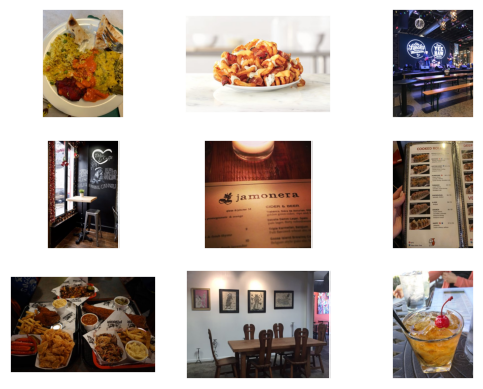

In [18]:
def get_original_photo_path(photo_id):
    return ORIGINAL_PHOTOS_DIR + 'photos/' + photo_id + '.jpg'

def get_work_photo_path(photo_id):
    return WORK_PHOTOS_DIR + photo_id + '.jpg'
    
photo_ids = []
for label in df_photos.label.unique():
    photo_ids = photo_ids + list(df_photos[df_photos.label == label].sample(SAMPLING_PHOTOS_SIZE, random_state=0)['photo_id'])
    
df_photos_sampling = pd.DataFrame({'photo_id': photo_ids, 'width': np.zeros(len(photo_ids)), 'height': np.zeros(len(photo_ids)), 'mode': np.full(len(photo_ids), '')})

sample_ids = list(df_photos_sampling.sample(9, random_state=1)['photo_id'])
for i in range(9):
    plt.subplot(330 + 1 + i)
    image = matplotlib.image.imread(get_original_photo_path(sample_ids[i]))
    plt.imshow(image)
    plt.grid(linewidth=0)
    plt.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
    plt.tick_params(axis='y', which='both', left=False, right=False, labelleft=False)
plt.show()

In [8]:
def fill_infos(df):
    for index in df.index:
        print(f'Lecture infos image {index+1}/{len(df)}', end='\r')
        photo_id = df.iloc[index]['photo_id']
        img = Image.open(get_original_photo_path(photo_id))
        
        w, h = img.size
        df.loc[df['photo_id']==photo_id, 'height'] = h   
        df.loc[df['photo_id']==photo_id, 'width'] = w
        df.loc[df['photo_id']==photo_id, 'mode'] = img.mode

fill_infos(df_photos_sampling)
df_photos_sampling.head()

,photo_id,width,height,mode
0,4bCgKE0Itp0T8wQXpYsypg,458.0,400.0,RGB
1,RN1AVvw1HXLceaNJkI0GdQ,300.0,400.0,RGB
2,XDVvq4N-wZV5jKVSUYXI2Q,300.0,400.0,RGB
3,IBCtJNh1XJApQSCSzLznlw,533.0,400.0,RGB
4,XIiiz9u9TY5CWjWlUW4pOg,533.0,400.0,RGB


In [9]:
df_photos_sampling.describe()

,width,height
count,500.000000,500.000000
mean,438.882000,389.688000
std,131.985303,32.814085
min,131.000000,69.000000
25%,300.000000,400.000000
50%,408.000000,400.000000
75%,543.750000,400.000000
max,600.000000,400.000000


In [10]:
df_photos_sampling['mode'].value_counts()

mode
RGB    500
Name: count, dtype: int64

## Pretraitement des images

In [19]:
def preprocess_images(df):
    for index in df.index:
        print(f'preprocess image {index+1}/{len(df)}', end='\r')
        photo_id = df.iloc[index]['photo_id']
        preprocess_image(photo_id)

def preprocess_image(photo_id, display_evo = False):
    original_path = get_original_photo_path(photo_id)
    if display_evo:
        img = display_img(original_path)
        img = histo_rgb(img)
    else:
        img = Image.open(original_path)
    
    img = treat_histogram(img)
    img = filter_img(img)
    new_path = save_img(current_path=original_path, img=img)

    if display_evo:
        img = display_img(new_path)
        img = histo_rgb(img)
    
    return new_path
    
def display_img(path):
    img = Image.open(path)
    display(img)
    return img

def histo_rgb(img):
    r, g, b = img.split()
    fig, axs = plt.subplots(1,3, figsize=(10,5), sharey=True)
    chans = {'rouge': r, 'vert': g, 'bleu':b}
    for index, name in enumerate(chans):
        chan_flat = np.array(chans[name]).flatten()
        ax = sns.histplot(chan_flat, bins=range(256), ax=axs[index])
        ax.set(ylabel=None,
               title=f'Channel: {name}')
    fig.supxlabel('Intensité')
    fig.supylabel('Nombre de pixels')
    plt.show()

    return img

def treat_histogram(img):
    # Equalize and autocontrast
    img = ImageOps.equalize(img)
    img = ImageOps.autocontrast(img)
    return img
    

def filter_img(img):
    # Apply gaussian blur
    img = img.filter(ImageFilter.MedianFilter(size=3))
    return img

def save_img(current_path, img):
    filename = os.path.basename(current_path)
    new_path = WORK_PHOTOS_DIR + filename
    img.save(new_path)

    return new_path

### Exemple de pre-traitement

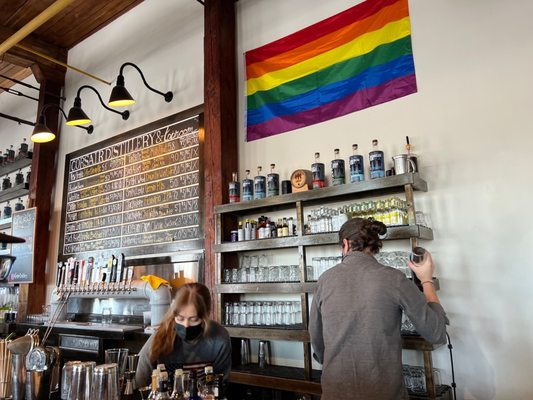

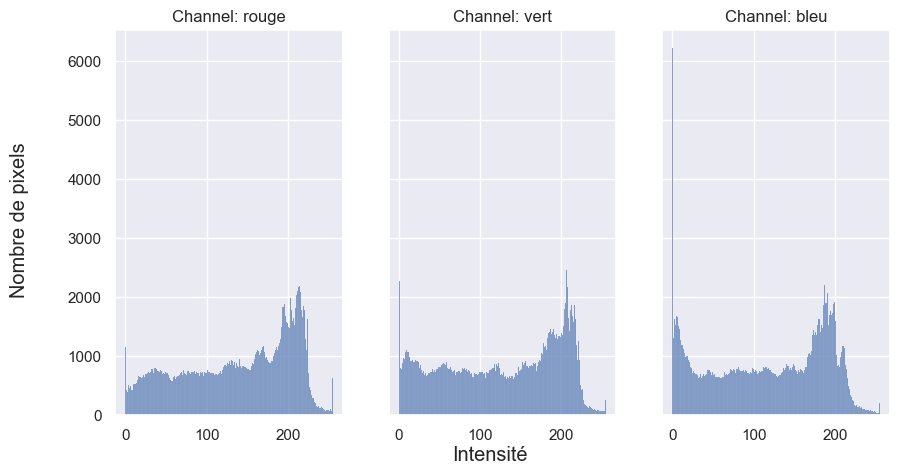

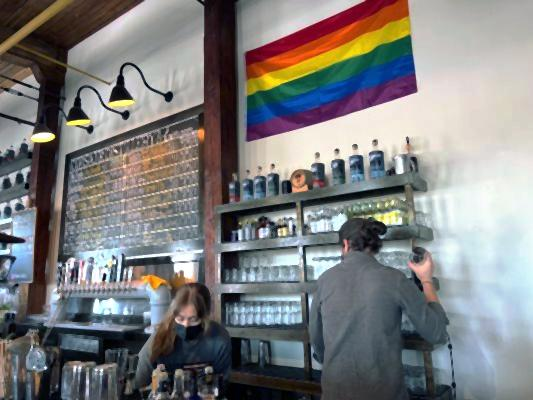

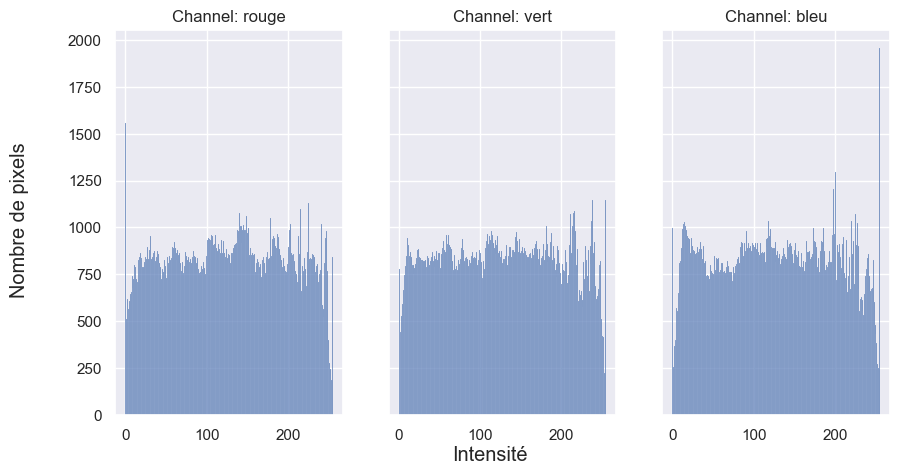

'data/work/yelp_photos/1KfbK9IcrbxY1lUkvN1aUA.jpg'

In [20]:
photo_id_sample = df_photos_sampling.sample(1, random_state=0)['photo_id'].iloc[0]
preprocess_image(photo_id_sample,display_evo=True)

### Pretaitement de l'ensemble de l'échantillon

In [21]:
if PREPROCESS_IMAGES:
    preprocess_images(df=df_photos_sampling)

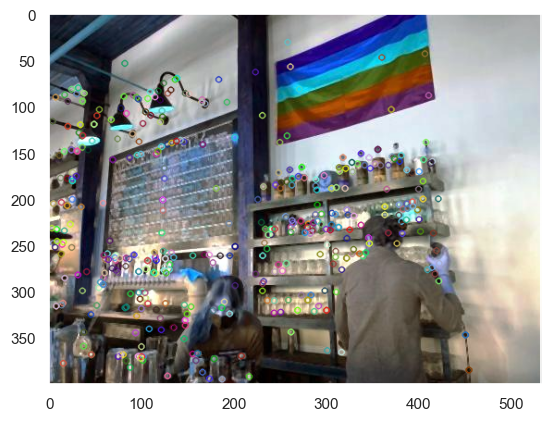

Descripteurs :  (501, 128)

[[ 0.  0.  0. ...  1. 18. 18.]
 [13. 14.  8. ... 24.  0.  1.]
 [24.  0.  0. ...  2.  5. 25.]
 ...
 [ 0.  0.  0. ...  0.  2.  8.]
 [ 0.  0.  0. ...  0.  2. 13.]
 [ 0.  0. 10. ...  0.  0. 12.]]


In [32]:
import cv2

sift = cv2.xfeatures2d.SIFT_create(500)
image = cv2.imread(get_work_photo_path(photo_id=photo_id_sample))
kp, des = sift.detectAndCompute(image, None)
img=cv2.drawKeypoints(image,kp,image)
plt.imshow(img)
plt.grid(linewidth=0)
plt.show()
print("Descripteurs : ", des.shape)
print()
print(des)

In [17]:
get_work_photo_path(photo_id=photo_id_sample)

'data/work/yelp_photos/photos/1KfbK9IcrbxY1lUkvN1aUA.jpg'